# **Environment SetUp For Project ⚙️**

**DEEP LEARNING PROJECT DL-1 LAB**

NAME: KUSH OZA

AGE AND GENDER PREDICTION

DATASET USED: UTK-FACE DATASET

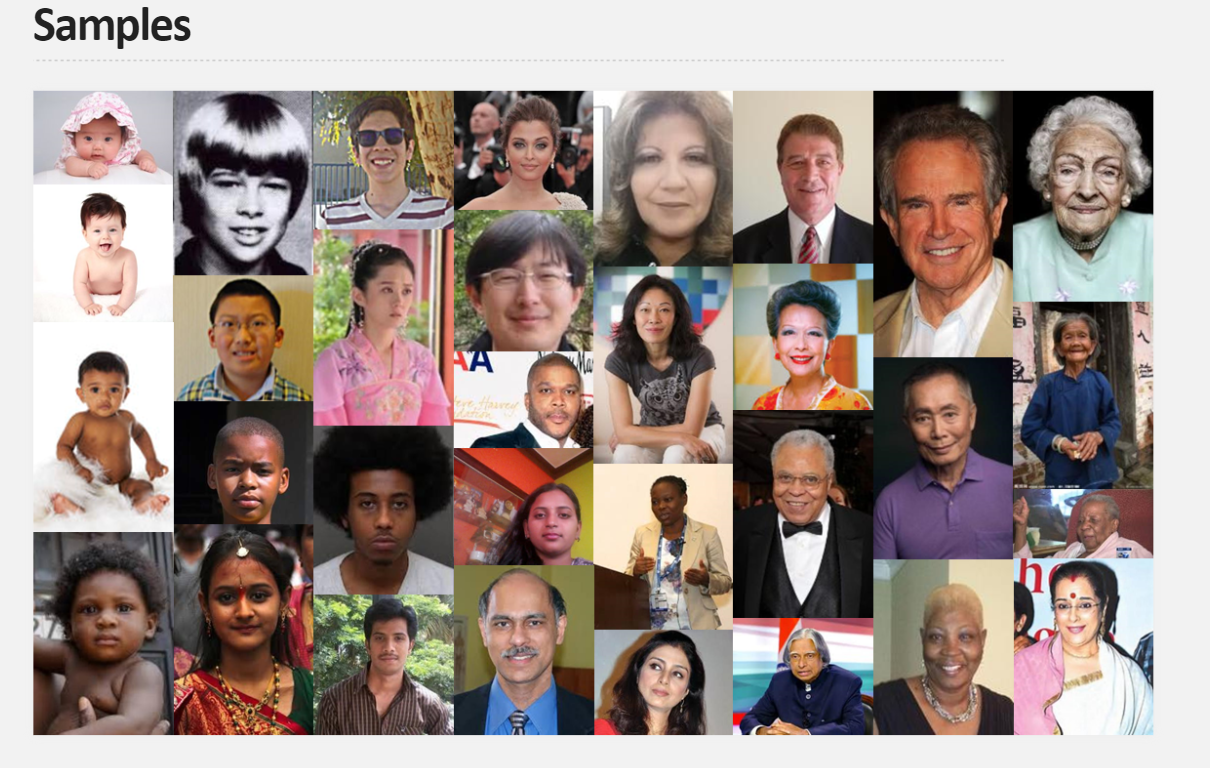

Before preprocessing and exploring the data  we will load **essential modules** like NumPy, Pandas, and TensorFlow.

In [2]:
# General
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

# Data
import plotly.express as px
import matplotlib.pyplot as plt

# Data Preprocessing
import tensorflow.data as tfds
from sklearn.model_selection import train_test_split
# for the final model , the libraries we need will be decided on a later stage
# here we will load and study our dataset
# we have utilized a dataset from kaggle: https://www.kaggle.com/datasets/jangedoo/utkface-new/code

2024-02-18 11:36:16.534733: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 11:36:16.534843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 11:36:16.663904: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Loading The Data** 

**UTK Face**

About Dataset
UTKFace dataset is a large-scale face dataset with long age span **(range from 0 to 116 years old)**. The dataset consists of over **20,000 face images** with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc. This dataset could be **used on a variety of tasks**, e.g., **face detection, age estimation, age progression/regression, landmark localization, etc.**

https://susanqq.github.io/UTKFace/

Total img        : 23708
sample image path: 80_0_0_20170117175301125.jpg.chip.jpg
sample's age     : 80
sample's gender  : Male


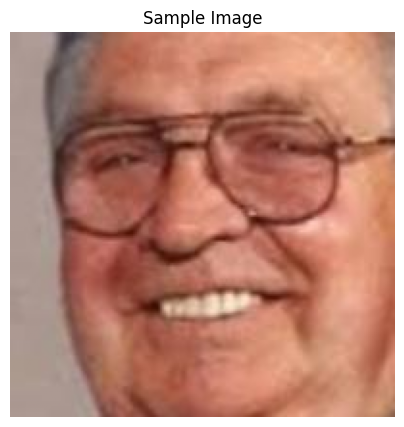

In [3]:
# here we will generate a random image from the dataset 

dir_path = "/kaggle/input/utkface-new/UTKFace/"
image_paths = os.listdir(dir_path)

gender_mapping = ["Male", "Female"]

# Choose and load an image randomly
rand_image_path = np.random.choice(image_paths)
rand_image = plt.imread(dir_path + rand_image_path)/255.
sample_age, sample_gender, *_ = rand_image_path.split("_")

print("Total img        :" ,   len(image_paths))
print("sample image path:"  , rand_image_path)
print("sample's age     :"   , sample_age)
print("sample's gender  :"   ,gender_mapping[int(sample_gender)])

plt.figure(figsize = (5,5))
plt.title("Sample Image")
plt.imshow(rand_image)
plt.axis("off")
plt.show()

# **IMPORTANT POINT**
The structure of the **image path**,there is age and gender—where the first part signifies age and the second denotes gender **(0 for male, 1 for female)** provides crucial information for subsequent analysis and categorization.

Careful management of these paths will facilitate targeted data processing based on age and gender attributes.

In [4]:
male_count = 0

ages = []

# Loop over the paths and check for male images.
# 12_0_0_20170110224843637.jpg.chip.jpg in this image name the number after 1st "_" 
# represents gender 0- male 1- female
for path in image_paths:
    path_split = path.split("_")
    if "0" == path_split[1]:
        male_count += 1
    ages.append(int(path_split[0]))

# find total female counts by subtracting from male counts
female_count = len(image_paths) - male_count

# Visualization
pie_chart = px.pie(
    names = gender_mapping,
    values = [male_count, female_count],
    title = "Gender Distribution Donut Chart",
    height = 500
)
pie_chart.show()

# There are close to 48 % females and 52 % males.
**Afte loading and understanding the data we observe that there are more number of males than females int the dataset**

 **we can also make a bar graph for proper visualization**
 
 **SEE BELOW**

In [5]:
bar_graph = px.bar(
    y = gender_mapping,
    x = [male_count, female_count],
    title = "Gender Distribution (Bar Graph)",
    color = gender_mapping,
    height = 500
)
bar_graph.update_layout(
    yaxis_title = "Gender",
    xaxis_title = "Frequency Count"
)
bar_graph.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [6]:
# Histogram
fig = px.histogram(sorted(ages), title = "Age Distribution")
fig.update_layout(
    xaxis_title = "Age",
    yaxis_title = "Value Counts"
)
fig.show()

In [7]:
# Box Plot
fig = px.box(x = sorted(ages), notched=True, title = "Age Distribution")
fig.update_layout(
    xaxis_title = "Age",
)
fig.show()

# Split the Dataset into Training,Testing and Validation set

In [8]:
# Split data into training, testing and validation set
train_images, test_images = train_test_split(
    image_paths,
    train_size = 0.8,
    test_size = 0.2
)

train_images, valid_images = train_test_split(
    image_paths,
    train_size = 0.8,
    test_size = 0.2
)

In [9]:
print("Train_Size: ",len(train_images))
print("Train_Size: ",len(test_images))

Train_Size:  18966
Train_Size:  4742


**WE NEED TO LABEL IMAGES IN EVERY SET WHICH IS TRAINING,TESTING AND VALIDATION WITH RESPECTIVE AGE AND GENDER. THIS WILL BE EXTRACTED FROM THE FILE-NAME**

**IF FILENAME IS 12_0_0_20170110224843637.jpg then "12" is the age of the person and the next 0 or 1 after this represents gender where**


**Male: 0**


**Female: 1**

In [10]:
train_ages = [int(path.split("_")[0]) for path in train_images]
train_genders = [int(path.split("_")[1]) for path in train_images]

valid_ages = [int(path.split("_")[0]) for path in valid_images]
valid_genders = [int(path.split("_")[1]) for path in valid_images]

test_ages = [int(path.split("_")[0]) for path in test_images]
test_genders = [int(path.split("_")[1]) for path in test_images]

In [11]:
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 224

In [12]:
def preprocess_age_data(image_path, age, gender, dir_path=dir_path, IMAGE_SIZE = IMAGE_SIZE):
    # Load the Image
    image = tf.io.read_file(dir_path + image_path)
    image = tf.io.decode_jpeg(image)

    # Resize and Normalize the Image
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.
    image = tf.cast(image, tf.float32)

    return image, age

In [13]:
def preprocess_gender_data(image_path, age, gender, dir_path=dir_path, IMAGE_SIZE = IMAGE_SIZE):
    # Load the Image
    image = tf.io.read_file(dir_path + image_path)
    image = tf.io.decode_jpeg(image)

    # Resize and Normalize the Image
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.
    image = tf.cast(image, tf.float32)

    return image, gender

In [14]:
train_ds = tfds.Dataset.from_tensor_slices((train_images, train_ages, train_genders)).shuffle(2000)
train_age_ds = train_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)
train_gender_ds = train_ds.map(preprocess_gender_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

In [15]:
valid_ds = tfds.Dataset.from_tensor_slices((valid_images, valid_ages, valid_genders)).shuffle(2000)
valid_age_ds = valid_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)
valid_gender_ds = valid_ds.map(preprocess_gender_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

In [16]:
test_ds  = tfds.Dataset.from_tensor_slices((test_images, test_ages, test_genders)).shuffle(500)
test_age_ds = test_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)
test_gender_ds = test_ds.map(preprocess_gender_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

# We will see our data post processing.

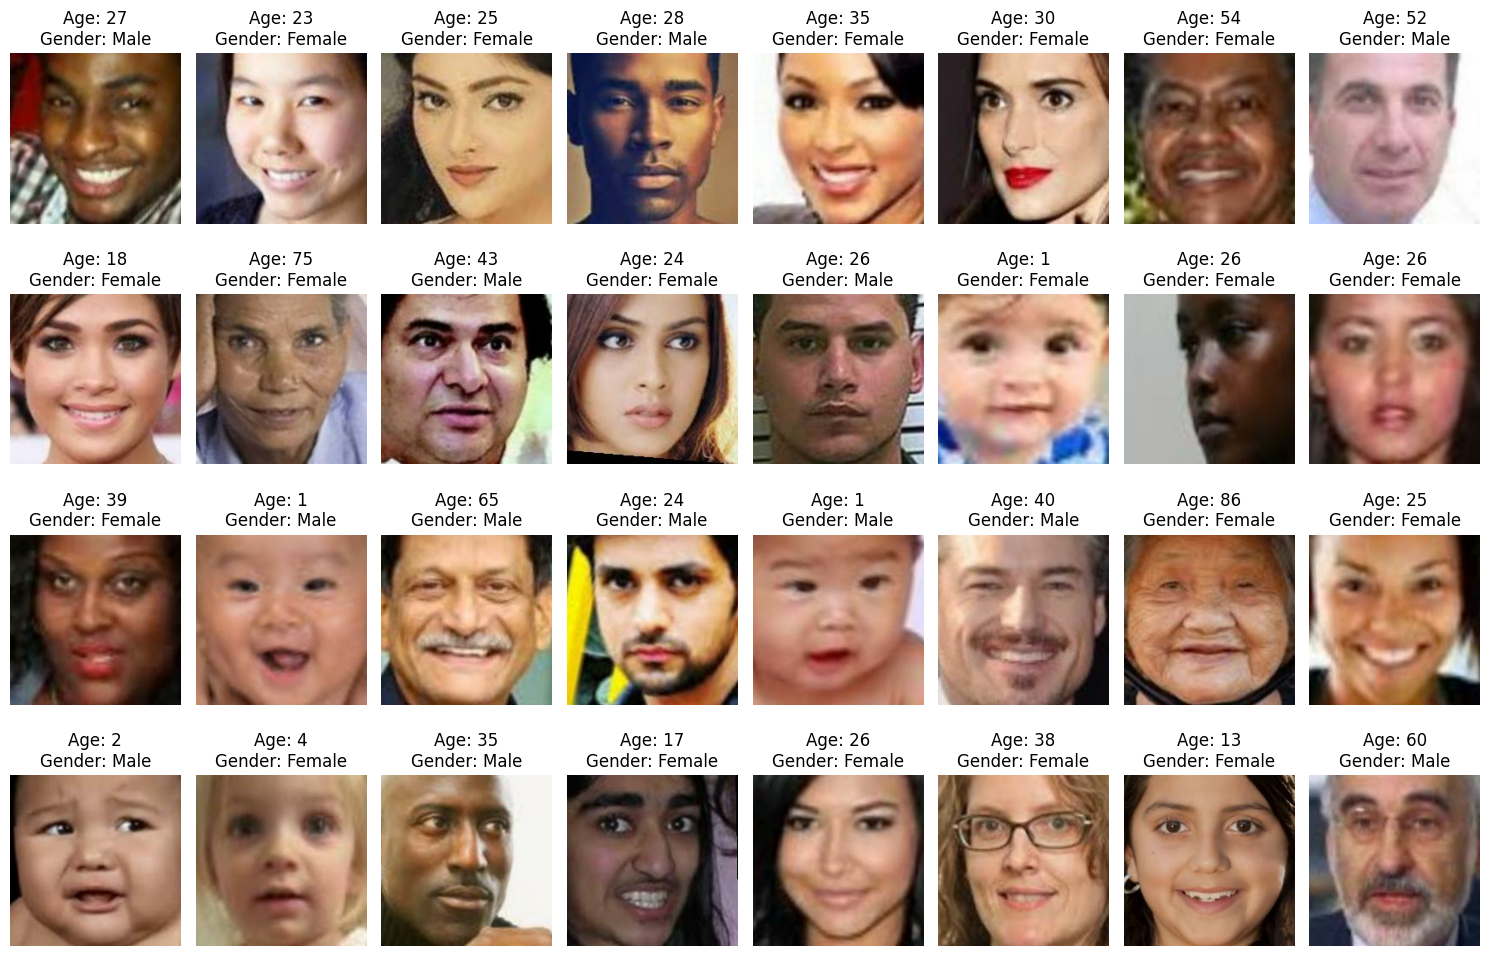

In [20]:
plt.figure(figsize=(15, 10))
for images, ages, genders in train_ds.batch(BATCH_SIZE).take(3):

    for index in range(len(images)):
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)
        plt.subplot(4, 8, index + 1)
        plt.imshow(image)
        plt.title(f"Age: {ages[index]}\nGender: {gender_mapping[genders[index]]}")
        plt.axis("off")

plt.tight_layout()
plt.show()

**We have successfully preprocessed our dataset.**